# Strategy

Choose stocks which are underperforming the S&P 500 according to their variation from the OLS regression between the stock and SPY. Use a pair of thresholds for the z-score and determine the cumulative returns.

# Get Data

In [1]:
import yfinance as yf
import pandas as pd

# Read and print the stock tickers that make up the S&P 500 - from https://gist.github.com/quantra-go-algo/ac5180bf164a7894f70969fa563627b2

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
look_back_window = 10 * 7
data_look_back = '6mo'

tickers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [2]:
sp_500_data = yf.download(tickers["Symbol"].to_list(), period=data_look_back, interval='1h',
                          auto_adjust=True)
sp_500_data

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo)')


Price                     Adj Close             Close                          \
Ticker                         BF.B BRK.B           A        AAPL        ABBV   
2024-09-20 13:30:00+00:00       NaN   NaN  138.809998  230.034500  193.057800   
2024-09-20 14:30:00+00:00       NaN   NaN  138.059998  229.770004  193.102402   
2024-09-20 15:30:00+00:00       NaN   NaN  138.449997  231.729996  192.630005   
2024-09-20 16:30:00+00:00       NaN   NaN  139.330002  230.750000  193.485001   
2024-09-20 17:30:00+00:00       NaN   NaN  139.172501  229.777206  192.860001   
...                             ...   ...         ...         ...         ...   
2025-03-19 15:30:00+00:00       NaN   NaN  122.950203  215.300003  212.195007   
2025-03-19 16:30:00+00:00       NaN   NaN  121.912498  214.380005  211.399902   
2025-03-19 17:30:00+00:00       NaN   NaN  121.894997  214.270004  211.050003   
2025-03-19 18:30:00+00:00       NaN   NaN  122.220001  215.509903  212.220001   
2025-03-19 19:30:00+00:00       NaN   NaN  122.230003  215.300003  212.160004   

Price                                                                      \
Ticker                           ABNB         ABT        ACGL         ACN   
2024-09-20 13:30:00+00:00  131.324997  113.779999  111.574997  334.214996   
2024-09-20 14:30:00+00:00  130.240005  114.074997  111.870003  334.000000   
2024-09-20 15:30:00+00:00  130.695007  113.705002  112.239998  334.524994   
2024-09-20 16:30:00+00:00  130.789993  113.860001  113.000000  334.950012   
2024-09-20 17:30:00+00:00  131.059998  113.690002  112.910004  334.470001   
...                               ...         ...         ...         ...   
2025-03-19 15:30:00+00:00  125.660004  126.949997   93.154999  324.412903   
2025-03-19 16:30:00+00:00  124.300003  126.489998   93.279999  322.690002   
2025-03-19 17:30:00+00:00  125.099998  126.415001   92.790001  322.049988   
2025-03-19 18:30:00+00:00  125.940002  127.410004   93.150002  323.510010   
2025-03-19 19:30:00+00:00  126.000000  127.430000   93.190002  324.420013   

Price                                  ...    Volume                       \
Ticker                           ADBE  ...       WTW         WY      WYNN   
2024-09-20 13:30:00+00:00  520.599976  ...  112192.0  1304082.0  271663.0   
2024-09-20 14:30:00+00:00  516.359985  ...   38666.0   326170.0  246407.0   
2024-09-20 15:30:00+00:00  518.020020  ...  120753.0   261288.0  123709.0   
2024-09-20 16:30:00+00:00  521.554993  ...   23744.0   302021.0  125257.0   
2024-09-20 17:30:00+00:00  521.395020  ...   26087.0   351175.0  139595.0   
...                               ...  ...       ...        ...       ...   
2025-03-19 15:30:00+00:00  389.445007  ...   32079.0   151512.0  192589.0   
2025-03-19 16:30:00+00:00  387.545013  ...   24560.0   124455.0  140270.0   
2025-03-19 17:30:00+00:00  387.510010  ...   31716.0   200238.0  103950.0   
2025-03-19 18:30:00+00:00  388.720001  ...   56329.0   495287.0  167473.0   
2025-03-19 19:30:00+00:00  387.720001  ...  128595.0   583363.0  238839.0   

Price                                                                          \
Ticker                           XEL        XOM       XYL       YUM       ZBH   
2024-09-20 13:30:00+00:00  1912415.0  4533789.0  260763.0  479349.0  271240.0   
2024-09-20 14:30:00+00:00   623755.0  1130481.0   86648.0  188694.0  219094.0   
2024-09-20 15:30:00+00:00   438378.0  1202492.0   51407.0  134307.0  270257.0   
2024-09-20 16:30:00+00:00   277897.0   724575.0   70661.0  144481.0  351523.0   
2024-09-20 17:30:00+00:00   259631.0  1218514.0   84005.0  180386.0  315582.0   
...                              ...        ...       ...       ...       ...   
2025-03-19 15:30:00+00:00   122111.0  1072865.0  108823.0   87369.0   87886.0   
2025-03-19 16:30:00+00:00   136308.0  1064904.0   81896.0   64371.0  122833.0   
2025-03-19 17:30:00+00:00   244605.0  1221657.0  217303.0  127333.0  129667.0   
2025-03-19 18:30:00+00:00   292492.0  1899652.0  23

In [3]:
sp_500_data.columns.map(lambda x: x[0]).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
sp_500_close_data = sp_500_data["Close"].dropna(axis=1, how="all").ffill()
sp_500_close_data

eastern_indices = sp_500_close_data.index.tz_convert('US/Eastern')
eastern_indices

DatetimeIndex(['2024-09-20 09:30:00-04:00', '2024-09-20 10:30:00-04:00',
               '2024-09-20 11:30:00-04:00', '2024-09-20 12:30:00-04:00',
               '2024-09-20 13:30:00-04:00', '2024-09-20 14:30:00-04:00',
               '2024-09-20 15:30:00-04:00', '2024-09-23 09:30:00-04:00',
               '2024-09-23 10:30:00-04:00', '2024-09-23 11:30:00-04:00',
               ...
               '2025-03-18 13:30:00-04:00', '2025-03-18 14:30:00-04:00',
               '2025-03-18 15:30:00-04:00', '2025-03-19 09:30:00-04:00',
               '2025-03-19 10:30:00-04:00', '2025-03-19 11:30:00-04:00',
               '2025-03-19 12:30:00-04:00', '2025-03-19 13:30:00-04:00',
               '2025-03-19 14:30:00-04:00', '2025-03-19 15:30:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', length=855, freq=None)

In [5]:
sp_500_close_data.set_index(eastern_indices, inplace=True)

In [6]:
sp_500_open_data = sp_500_data["Open"].dropna(axis=1, how="all").ffill()
eastern_indices = sp_500_open_data.index.tz_convert('US/Eastern')
sp_500_open_data.set_index(eastern_indices, inplace=True)

sp_500_open_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-20 09:30:00-04:00,141.210007,229.970001,193.000000,129.830002,113.750000,111.550003,332.545013,526.440002,232.479996,62.000000,...,288.170013,33.660000,79.930000,64.441002,115.459999,135.820007,130.759995,105.570000,362.429993,192.940002
2024-09-20 10:30:00-04:00,138.774994,230.029999,193.020004,131.349899,113.779999,111.570000,334.089996,520.580017,227.009995,61.430000,...,287.475006,33.418301,78.660004,64.449997,114.709999,135.110001,129.960007,105.870003,363.579987,192.684998
2024-09-20 11:30:00-04:00,138.059998,229.759995,193.074997,130.229996,114.078003,111.830002,334.000000,516.359985,225.009995,61.189999,...,287.559998,33.189999,79.110001,64.495003,114.610001,134.179993,129.869995,106.214996,363.545013,192.550003
2024-09-20 12:30:00-04:00,138.479996,231.720001,192.634995,130.669998,113.699997,112.214996,334.440002,518.140015,226.792496,61.349998,...,288.584991,33.224998,79.230003,64.470001,114.889999,134.600006,129.520004,106.004997,366.170013,191.750000
2024-09-20 13:30:00-04:00,139.389999,230.740005,193.479996,130.789993,113.870003,112.995003,334.910004,521.489990,225.740005,61.259998,...,288.769989,33.215000,79.110001,64.620003,115.360001,134.669998,129.820007,106.540001,366.140015,191.899994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-19 11:30:00-04:00,122.750000,215.690002,211.589996,126.070000,126.753403,93.245003,324.279999,391.230011,209.509995,47.299999,...,335.299988,29.620001,85.360001,70.014999,114.959999,121.279999,157.940002,113.209999,285.880005,164.095001
2025-03-19 12:30:00-04:00,123.040001,215.289993,212.145004,125.610001,126.957603,93.160004,324.369995,389.445007,210.363998,47.065601,...,335.559998,29.690001,84.739998,70.169998,114.739998,121.529999,158.089996,113.199997,286.714996,164.740005
2025-03-19 13:30:00-04:00,121.945000,214.391998,211.399994,124.320000,126.489998,93.269997,322.674988,387.459991,209.345001,46.970001,...,333.910004,29.598499,84.779999,70.214996,115.004997,121.004997,157.395004,112.309998,285.160004,164.529999
2025-03-19 14:30:00-04:00,121.879997,214.270004,210.975006,125.150002,126.440002,92.860001,322.054993,387.549988,209.029999,46.759998,...,334.114990,29.735001,85.300003,70.279999,114.750000,120.385002,157.179993,111.930000,285.200012,163.559998


# Experimentation

In [7]:
sp_500_close_data.index.hour

Index([ 9, 10, 11, 12, 13, 14, 15,  9, 10, 11,
       ...
       13, 14, 15,  9, 10, 11, 12, 13, 14, 15],
      dtype='int32', length=855)

In [8]:
tickers["GICS Sector"].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [9]:
sectors_to_tickers = {
    "Industrials": "SP500-20",
    "Health Care": "SP500-35",
}

yf.download(["SP500-20", "SP500-35"], period=data_look_back, interval='1h',
                          auto_adjust=True)

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['SP500-20', 'SP500-35']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')


Empty DataFrame
Columns: [(Adj Close, SP500-20), (Adj Close, SP500-35), (Close, SP500-20), (Close, SP500-35), (High, SP500-20), (High, SP500-35), (Low, SP500-20), (Low, SP500-35), (Open, SP500-20), (Open, SP500-35), (Volume, SP500-20), (Volume, SP500-35)]
Index: []

In [10]:
wednesday_first_hour_closing_px = sp_500_close_data[
    (sp_500_close_data.index.weekday == 2) & (sp_500_close_data.index.hour == 9)]
wednesday_first_hour_closing_px

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-18 09:30:00-04:00,138.429993,220.735001,193.860001,123.320000,115.714996,113.709999,334.320007,508.700012,224.729996,60.369999,...,293.029999,33.099998,78.860001,64.540001,113.900002,132.979996,132.789993,105.730003,349.500000,195.320007
2024-09-25 09:30:00-04:00,141.520004,226.384995,192.740005,130.730698,112.320000,112.820000,337.940002,521.690002,226.490005,58.980000,...,290.679993,33.630001,84.010002,64.309998,115.269997,133.770004,132.570007,107.169998,364.839996,194.149994
2024-10-02 09:30:00-04:00,146.440002,225.419998,195.925003,125.529999,113.050003,113.440002,354.459991,509.829895,228.289993,59.380001,...,298.894989,33.630001,100.190002,65.209999,121.769997,134.529907,139.119995,106.040001,367.364990,193.720001
2024-10-09 09:30:00-04:00,144.470001,227.100006,192.360001,133.434998,114.709999,111.235001,362.406006,493.160004,230.520004,57.450001,...,293.160004,32.900002,103.260002,62.630001,121.400002,135.070007,135.080002,101.620003,372.265015,187.229996
2024-10-16 09:30:00-04:00,140.990005,230.729706,189.660004,135.934998,119.059998,108.650002,370.279999,502.704987,229.865005,58.000099,...,292.470001,33.345001,100.739998,63.790001,121.000000,137.309479,133.300003,105.224998,378.799988,195.009995
2024-10-23 09:30:00-04:00,132.350006,234.720001,188.229996,134.789993,116.370003,106.805000,370.575012,489.179993,228.300003,55.630001,...,290.720001,31.709999,98.660004,63.945000,120.419998,132.455994,134.673706,104.139999,370.535004,188.445007
2024-10-30 09:30:00-04:00,133.455002,231.860001,193.729996,138.229996,113.620003,105.125000,354.262512,489.309998,232.259995,56.360001,...,293.429993,31.670000,98.650002,62.759998,117.500000,130.149994,133.904999,109.129997,382.190002,182.384995
2024-11-06 09:30:00-05:00,137.634995,225.651306,203.309998,141.464996,116.010002,100.699997,355.179993,504.265015,224.850006,52.174999,...,313.309998,31.500000,86.953201,66.089996,121.364998,123.419998,132.070007,109.559998,385.515015,173.259995
2024-11-13 09:30:00-05:00,133.440002,223.210007,170.932495,134.149994,116.214996,100.830002,364.459991,528.659973,215.220001,51.630001,...,316.670013,30.950001,85.610001,68.760002,119.300003,124.449997,135.914993,109.305000,400.820007,175.279999
2024-11-20 09:30:00-05:00,126.379997,226.514999,165.970001,134.759995,116.059998,94.870003,352.600006,496.309998,208.759995,53.334999,...,307.470001,30.799999,90.940002,69.760002,119.245003,121.879997,132.345001,109.894997,386.059998,176.270004


In [11]:
sp_500_close_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-18 09:30:00-04:00,138.429993,220.735001,193.860001,123.320000,115.714996,113.709999,334.320007,508.700012,224.729996,60.369999,...,293.029999,33.099998,78.860001,64.540001,113.900002,132.979996,132.789993,105.730003,349.500000,195.320007
2024-09-18 10:30:00-04:00,138.509995,220.630005,193.664993,122.730003,115.500000,113.779999,334.179993,510.390015,224.029999,60.380001,...,293.200012,33.125000,78.889999,64.474998,114.449997,132.839996,132.380005,105.779999,350.214996,194.994995
2024-09-18 11:30:00-04:00,138.419998,220.809998,193.669998,122.629997,115.750000,113.930000,334.119995,509.565002,223.919998,60.455002,...,292.919312,33.084999,78.535004,64.470802,114.419998,132.800003,132.002502,105.669998,350.814789,195.190002
2024-09-18 12:30:00-04:00,138.119995,221.210098,194.429993,123.040001,115.650002,113.945000,336.017487,510.390015,223.710007,60.439999,...,292.920013,33.110001,78.459999,64.519997,114.870003,132.729996,131.449997,105.489998,348.940002,195.735001
2024-09-18 13:30:00-04:00,140.330002,221.407303,193.940002,124.779999,115.389999,113.220001,337.204987,509.570007,226.520004,60.680000,...,291.329987,33.415001,79.555298,64.137497,114.900002,134.220001,130.889999,106.000000,354.059998,197.490005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-17 11:30:00-04:00,121.860001,211.199997,214.259995,126.070000,127.203697,94.162498,323.237488,389.890015,208.585007,48.360001,...,327.250000,30.020000,86.169998,70.245003,114.080002,123.410004,156.309998,111.605003,282.024994,164.223206
2025-03-17 12:30:00-04:00,122.120003,212.330307,214.660004,126.739998,127.269997,94.650002,323.690002,391.760010,209.639999,48.310001,...,327.262512,30.109800,86.739998,70.345703,114.230003,123.750000,156.460007,112.050003,283.385010,164.725006
2025-03-17 13:30:00-04:00,122.660004,214.455002,214.889999,127.750000,127.614998,94.660004,325.140015,396.929993,211.970001,48.115002,...,327.910004,30.195000,86.705002,70.160004,114.269997,124.150002,156.699997,112.675003,285.394989,165.210007
2025-03-17 14:30:00-04:00,123.150002,214.684998,215.050003,127.750000,127.370003,95.089996,324.410004,396.654999,212.559998,48.174999,...,327.679993,30.045000,86.790001,69.945000,114.180000,123.930000,157.095001,112.125000,287.190002,165.514999


In [12]:
# F, PTC, NVDA

# PTC

# bought 1 share for $168.84
start_datetime = pd.to_datetime("2025-02-10 09:30-05:00")
sp_500_close_data["PTC"].loc[start_datetime:]

2025-02-10 09:30:00-05:00    168.600006
2025-02-10 10:30:00-05:00    167.699997
2025-02-10 11:30:00-05:00    166.850006
2025-02-10 12:30:00-05:00    166.479996
2025-02-10 13:30:00-05:00    166.729996
                                ...    
2025-03-17 11:30:00-04:00    158.350006
2025-03-17 12:30:00-04:00    159.300003
2025-03-17 13:30:00-04:00    160.074997
2025-03-17 14:30:00-04:00    159.948395
2025-03-17 15:30:00-04:00    158.850006
Name: PTC, Length: 175, dtype: float64

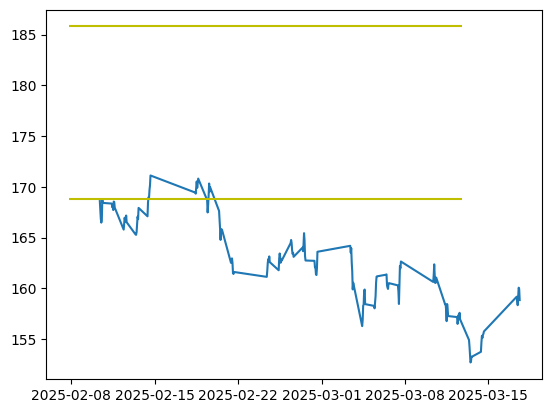

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(sp_500_close_data["PTC"].loc[start_datetime:])
ax.hlines(y=168.84, xmin=20127, xmax=20160, color='y')
ax.hlines(y=185.79, xmin=20127, xmax=20160, color='y')

In [14]:
(sp_500_close_data["PTC"].loc[start_datetime:] > 168.84 * 1.01).astype(int).sum()

3

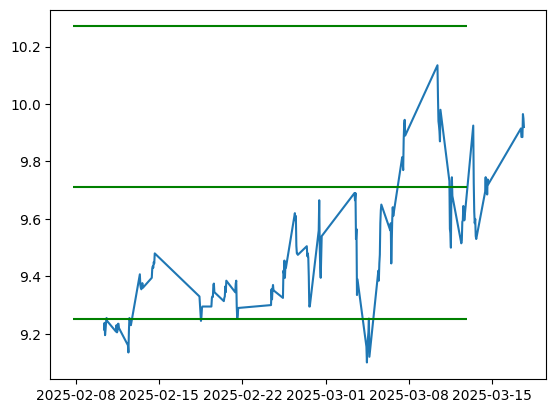

In [15]:
fig, ax = plt.subplots()
ax.plot(sp_500_close_data["F"].loc[start_datetime:])
ax.hlines(y=9.25, xmin=20127, xmax=20160, color='g')
ax.hlines(y=9.25 * 1.05, xmin=20127, xmax=20160, color='g')
ax.hlines(y=10.27, xmin=20127, xmax=20160, color='g')

In [16]:
(sp_500_close_data["F"].loc[start_datetime:] > 9.25 * 1.05).astype(int).sum()

29

In [17]:
sp_500_close_data["F"].loc[start_datetime:][sp_500_close_data["F"].loc[start_datetime:] > 9.25 * 1.05]

2025-03-07 09:30:00-05:00     9.8150
2025-03-07 10:30:00-05:00     9.7988
2025-03-07 11:30:00-05:00     9.7700
2025-03-07 12:30:00-05:00     9.8770
2025-03-07 13:30:00-05:00     9.9280
2025-03-07 14:30:00-05:00     9.9450
2025-03-07 15:30:00-05:00     9.8900
2025-03-10 09:30:00-04:00    10.1350
2025-03-10 10:30:00-04:00    10.0250
2025-03-10 11:30:00-04:00     9.9401
2025-03-10 12:30:00-04:00     9.9250
2025-03-10 13:30:00-04:00     9.9050
2025-03-10 14:30:00-04:00     9.8700
2025-03-10 15:30:00-04:00     9.9800
2025-03-11 09:30:00-04:00     9.7317
2025-03-11 14:30:00-04:00     9.7450
2025-03-13 09:30:00-04:00     9.9250
2025-03-13 10:30:00-04:00     9.7250
2025-03-14 10:30:00-04:00     9.7453
2025-03-14 12:30:00-04:00     9.7300
2025-03-14 14:30:00-04:00     9.7375
2025-03-14 15:30:00-04:00     9.7200
2025-03-17 09:30:00-04:00     9.9150
2025-03-17 10:30:00-04:00     9.8854
2025-03-17 11:30:00-04:00     9.8850
2025-03-17 12:30:00-04:00     9.8850
2025-03-17 13:30:00-04:00     9.9650
2

In [56]:
9.25 * 1.05

9.7125

In [5]:
sp_500_recent_data = yf.download(tickers["Symbol"].to_list(), period='1d', interval='1h',
                                 auto_adjust=True)
sp_500_recent_data

[*****                 11%                       ]  54 of 503 completed

KeyboardInterrupt: 

In [5]:
sp_500_close_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-09 09:30:00-04:00,138.809998,218.875000,194.949997,116.870003,115.510002,111.415001,339.950012,570.489990,217.490005,59.875000,...,292.054993,30.254999,77.150002,62.970001,114.080002,129.350006,133.429993,105.730003,325.600006,192.214996
2024-09-09 10:30:00-04:00,138.389999,218.960007,195.720001,116.184998,115.940002,111.589996,339.445007,568.205017,217.309998,59.610001,...,292.970001,30.320000,77.129997,63.189999,115.345001,129.304993,133.024994,105.565002,325.029999,192.570007
2024-09-09 11:30:00-04:00,139.110001,220.203903,196.100006,117.105003,116.349998,112.150002,341.579987,572.159973,218.479996,59.830002,...,294.049988,30.360001,77.389999,63.340000,115.860001,129.600006,132.789993,105.919998,327.049988,193.134995
2024-09-09 12:30:00-04:00,138.824997,220.839996,196.156204,117.629898,116.525002,112.264999,341.899994,573.929993,218.369995,59.865002,...,294.730011,30.365000,77.360001,63.485001,115.930000,129.610001,132.785004,106.199997,327.160004,193.089996
2024-09-09 13:30:00-04:00,138.029999,217.169998,196.300003,117.489998,116.449997,112.129997,340.698395,567.549988,217.401596,59.825001,...,293.980011,30.310101,77.110001,63.560001,115.779999,129.380005,132.904999,105.830002,327.209991,192.533997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 11:30:00-05:00,125.394997,239.289993,213.319901,130.949997,136.000000,90.820000,337.309998,443.290009,220.897507,49.965000,...,328.529999,30.245001,86.639999,67.860001,109.680000,127.610001,161.615005,106.669998,288.000000,168.970001
2025-03-07 12:30:00-05:00,126.724998,240.414398,214.373001,132.479996,136.824997,91.230003,340.454987,446.209991,222.580002,49.560001,...,330.279999,30.514999,87.794998,68.139999,109.525497,129.115005,162.625000,107.485001,292.089996,170.740005
2025-03-07 13:30:00-05:00,127.269997,239.649994,213.949997,134.354996,137.274994,91.334999,341.720001,450.599915,225.804993,49.445000,...,331.290009,30.655001,88.000000,68.010002,109.650002,129.809998,162.720001,108.044998,292.429993,170.039993
2025-03-07 14:30:00-05:00,127.495003,238.811401,214.669998,133.949997,137.225006,91.430000,340.929993,450.760010,225.770004,49.494999,...,331.799988,30.770000,88.339996,67.720001,109.254997,130.365005,162.759995,107.434998,293.109985,170.309998


In [6]:
mean_std_pairs = []

for ticker in sp_500_close_data.columns:
    mean_std_pairs.append((sp_500_close_data[ticker].mean(), sp_500_close_data[ticker].std()))


mean_std_pairs

[(138.61138036245535, 6.6359320552823275),
 (234.33130976772088, 9.673806696669086),
 (187.00841380603904, 11.80949126653775),
 (134.13357704144897, 7.336440747190584),
 (119.39544777748479, 7.68383207630065),
 (99.26412454945859, 8.460378109094293),
 (360.3564303015335, 13.710403283391303),
 (480.67255414002454, 40.33991727317869),
 (220.9458311041104, 8.712286646316636),
 (52.97632633837636, 4.440202333276373),
 (295.77331426138113, 11.128199495873126),
 (290.6501586984869, 15.789661433564588),
 (90.98109072267042, 4.565491475252028),
 (98.647204131372, 4.0985411255797635),
 (14.136829566513025, 3.0161958243866667),
 (107.74852498667423, 3.7378648348384957),
 (75.11410476436748, 2.4307963762131077),
 (206.5354073473583, 10.772652030683908),
 (297.28383896688297, 16.66775496347741),
 (96.33374988175323, 6.596580560559372),
 (92.44126310591908, 9.917115022338352),
 (220.76746660484793, 17.97645208219297),
 (192.26791077368222, 5.752482852482947),
 (137.3633813437619, 7.105876053508319)

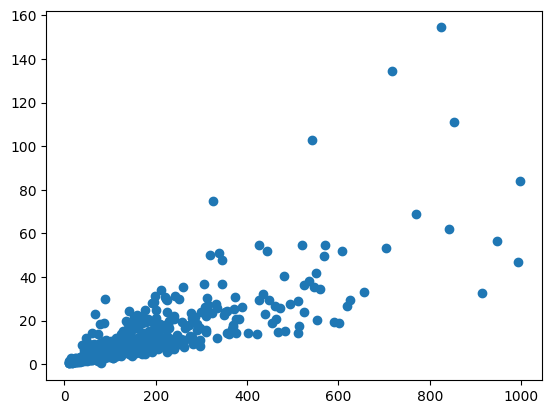

In [9]:
import matplotlib.pyplot as plt

plt.scatter([x[0] for x in mean_std_pairs if x[0] < 1000], [x[1] for x in mean_std_pairs if x[0] < 1000])
plt.show()

In [13]:
mean_std_tuples = []
for ticker in sp_500_close_data.columns:
    mean_std_tuples.append(
        (1 / sp_500_close_data[ticker].iloc[-100:].std(), ticker)
        #(sp_500_close_data[ticker].iloc[-100:].mean() / sp_500_close_data[ticker].iloc[-100:].std(), ticker)
    )

sorted(mean_std_tuples)

[(0.007313221953264696, 'BKNG'),
 (0.009122330306389505, 'NVR'),
 (0.013300228152579446, 'AZO'),
 (0.015207437085348736, 'FICO'),
 (0.016859582891191143, 'AXON'),
 (0.020313320404338756, 'TPL'),
 (0.023247050347938947, 'MPWR'),
 (0.023984436206712374, 'NFLX'),
 (0.026078974792540656, 'NOW'),
 (0.02672427092884494, 'CEG'),
 (0.0273067608584615, 'URI'),
 (0.028407330544198927, 'TSLA'),
 (0.029227773000171094, 'CRWD'),
 (0.03109695138572534, 'GS'),
 (0.034622022914178055, 'KLAC'),
 (0.034899857413707484, 'META'),
 (0.03755312895139628, 'ERIE'),
 (0.03819746372379227, 'ORLY'),
 (0.03921924289485685, 'GEV'),
 (0.03994917216175396, 'SNPS'),
 (0.04037652979918099, 'ISRG'),
 (0.040475902065435984, 'PH'),
 (0.04073602688559189, 'COST'),
 (0.04231158333063993, 'LLY'),
 (0.04235063417971538, 'TDG'),
 (0.04565674890050671, 'LII'),
 (0.04672167514813232, 'MLM'),
 (0.046809415851056475, 'MTD'),
 (0.04835047049674059, 'EPAM'),
 (0.05000371908891036, 'EQIX'),
 (0.05046872236846269, 'TFX'),
 (0.0505729

In [43]:
rets_in_day = (sp_500_close_data / sp_500_close_data.shift(6)) - 1
rets_in_day[rets_in_day.index.hour == 15].iloc[-1].sort_values()

Ticker
TECH   -0.052973
PARA   -0.036165
DVA    -0.035442
JKHY   -0.034613
BBY    -0.033463
          ...   
VST     0.041344
CCL     0.042576
NCLH    0.047141
BA      0.050689
SMCI    0.088196
Name: 2025-03-11 15:30:00-04:00, Length: 501, dtype: float64

In [12]:
t = pd.to_datetime("2024-09-12 09:30:00-04:00")
t.date()

datetime.date(2024, 9, 12)

In [47]:
(sp_500_close_data.std() / sp_500_close_data.mean()).iloc[-100:].sort_values()

Ticker
TEL     0.025115
SPGI    0.028724
ZBH     0.028976
UNP     0.031019
TYL     0.032264
          ...   
VST     0.162070
UAL     0.207925
TPR     0.226835
TSLA    0.227651
SMCI    0.233036
Length: 100, dtype: float64

# Start Here

In [9]:
ticker_to_sector = dict()
for item in tickers.iterrows():
    ticker_to_sector[item[1]["Symbol"]] = item[1]["GICS Sector"]

ticker_to_sector
# tickers[["Symbol", "GICS Sector"]]

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ADBE': 'Information Technology',
 'AMD': 'Information Technology',
 'AES': 'Utilities',
 'AFL': 'Financials',
 'A': 'Health Care',
 'APD': 'Materials',
 'ABNB': 'Consumer Discretionary',
 'AKAM': 'Information Technology',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Communication Services',
 'GOOG': 'Communication Services',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AMCR': 'Materials',
 'AEE': 'Utilities',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',
 'AME': 'Industrials',
 'AMGN': 'Health Care',
 'APH': 'Information Technology',
 'ADI': 'Information Technology',
 'ANSS': 'Information Technology',
 'AON': 'Financials',
 'APA': 'Energy',
 'APO': 'Financia

In [10]:
near_day_end_close_data = sp_500_close_data[sp_500_close_data.index.hour == 15]
near_day_end_close_data.index = near_day_end_close_data.index.map(lambda x: x.date())
near_day_end_close_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-20,140.089996,228.529999,193.460007,131.179993,113.690002,113.230003,336.119995,522.109985,226.839996,61.349998,...,288.339996,33.250000,79.709999,64.120003,115.279999,134.789993,129.690002,106.449997,366.760010,192.619995
2024-09-23,139.770004,226.449997,193.820007,129.070007,114.790001,113.660004,339.119995,527.710022,225.990005,60.919998,...,290.730011,33.549999,80.209999,63.970001,117.360001,134.520004,130.369995,107.580002,362.440002,193.600006
2024-09-24,141.899994,227.360001,193.639999,131.500000,113.389999,113.360001,339.630005,524.159973,227.339996,60.740002,...,289.339996,33.785000,84.160004,64.169998,117.080002,133.059998,133.830002,107.830002,364.359985,193.690002
2024-09-25,139.440002,226.309998,191.270004,130.690002,112.629997,113.089996,337.000000,517.909973,226.649994,58.139999,...,290.470001,32.980000,84.169998,64.180000,114.739998,133.639999,133.119995,106.550003,364.869995,191.539993
2024-09-26,146.710007,227.619995,191.869995,129.259995,112.690002,112.580002,355.630005,515.559998,232.460007,59.369999,...,291.220001,33.150002,91.029999,63.990002,112.790001,134.169998,138.059998,107.709999,371.339996,194.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,117.300003,209.710007,211.550003,119.379997,129.869995,90.370003,317.070007,377.390015,203.869995,47.250000,...,319.170013,28.965000,83.269997,68.669998,108.650002,121.000000,153.429993,107.690002,271.640015,160.050003
2025-03-14,121.190002,213.380005,211.695007,122.838997,126.639999,92.550003,318.739990,394.339996,208.699997,47.189999,...,324.570007,29.469999,86.260002,69.739998,111.864998,122.699997,155.029999,109.919998,278.799988,161.199997
2025-03-17,122.510002,214.190002,214.470001,126.949997,127.629997,95.269997,325.760010,399.329987,211.699997,48.009998,...,328.529999,29.969999,86.400002,69.959999,113.794998,123.110001,157.139999,111.839996,285.399994,165.199997
2025-03-18,123.129997,212.789993,213.949997,124.559998,126.309998,93.269997,324.144989,391.230011,209.229996,47.680000,...,335.160004,29.850000,85.449997,70.269997,113.650002,120.949997,157.330002,112.849998,282.579987,164.419998


In [11]:
day_open_data = sp_500_open_data[sp_500_open_data.index.hour == 9]
day_open_data.index = day_open_data.index.map(lambda x: x.date())
day_open_data

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-20,141.210007,229.970001,193.000000,129.830002,113.750000,111.550003,332.545013,526.440002,232.479996,62.000000,...,288.170013,33.660000,79.930000,64.441002,115.459999,135.820007,130.759995,105.570000,362.429993,192.940002
2024-09-23,141.149994,227.339996,193.699997,131.500000,113.790001,113.610001,337.380005,524.984985,224.485001,60.980000,...,288.609985,33.430000,79.889999,64.349998,115.330002,135.270004,129.830002,107.279999,367.339996,192.809998
2024-09-24,140.100006,229.179993,192.949997,130.580002,114.209999,113.339996,337.940002,527.719971,228.639999,61.290001,...,290.309998,33.419998,83.589996,63.580002,117.839996,133.949997,131.649994,107.599998,364.000000,194.960007
2024-09-25,141.970001,224.929993,194.000000,131.309998,113.820000,113.910004,335.140015,524.880005,224.100006,60.750000,...,291.010010,33.720001,83.760002,64.480003,116.485001,133.729996,133.800003,108.190002,364.630005,193.839996
2024-09-26,141.259995,227.300003,190.100006,132.705994,112.309998,112.485001,355.010010,520.429993,232.250000,58.160000,...,289.079987,33.250000,89.889999,63.950001,111.139999,134.899994,134.279999,106.889999,370.000000,192.119995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,119.000000,215.940002,212.000000,124.989998,130.279999,89.000000,323.690002,405.269989,206.000000,47.080002,...,321.140015,29.230000,84.940002,69.269997,108.330002,122.860001,154.360001,104.430000,279.000000,161.500000
2025-03-14,118.809998,211.250000,209.779999,121.949997,125.000000,90.750000,316.410004,380.000000,207.500000,47.240002,...,320.750000,29.200001,84.434998,68.099998,108.940002,122.529999,153.419998,107.120003,275.839996,159.910004
2025-03-17,121.099998,213.360001,212.220001,124.000000,126.720001,91.949997,320.000000,393.549988,207.750000,47.349998,...,323.899994,29.490000,86.525002,69.699997,111.800003,122.500000,154.335007,109.949997,278.470001,160.000000
2025-03-18,122.099998,214.139999,214.470001,126.000000,127.949997,95.410004,323.640015,395.359985,210.580002,48.029999,...,332.750000,30.040001,86.410004,69.739998,114.089996,122.669998,156.710007,111.660004,282.720001,164.399994


In [12]:
day_returns = near_day_end_close_data / day_open_data - 1
day_returns

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-09-20,-0.007932,-0.006262,0.002383,0.010398,-0.000527,0.015061,0.010750,-0.008225,-0.024260,-0.010484,...,0.000590,-0.012181,-0.002752,-0.004981,-0.001559,-0.007584,-0.008183,0.008336,0.011947,-0.001659
2024-09-23,-0.009777,-0.003915,0.000620,-0.018479,0.008788,0.000440,0.005157,0.005191,0.006704,-0.000984,...,0.007346,0.003590,0.004006,-0.005905,0.017602,-0.005544,0.004159,0.002796,-0.013339,0.004097
2024-09-24,0.012848,-0.007941,0.003576,0.007045,-0.007180,0.000176,0.005001,-0.006746,-0.005686,-0.008974,...,-0.003341,0.010922,0.006819,0.009280,-0.006449,-0.006644,0.016559,0.002138,0.000989,-0.006514
2024-09-25,-0.017821,0.006135,-0.014072,-0.004722,-0.010455,-0.007199,0.005550,-0.013279,0.011379,-0.042963,...,-0.001856,-0.021945,0.004895,-0.004653,-0.014980,-0.000673,-0.005082,-0.015159,0.000658,-0.011865
2024-09-26,0.038581,0.001408,0.009311,-0.025967,0.003384,0.000845,0.001746,-0.009358,0.000904,0.020805,...,0.007403,-0.003007,0.012682,0.000626,0.014846,-0.005411,0.028150,0.007671,0.003622,0.014730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,-0.014286,-0.028851,-0.002123,-0.044884,-0.003147,0.015393,-0.020452,-0.068794,-0.010340,0.003611,...,-0.006134,-0.009066,-0.019661,-0.008662,0.002954,-0.015139,-0.006025,0.031217,-0.026380,-0.008978
2025-03-14,0.020032,0.010083,0.009129,0.007290,0.013120,0.019835,0.007364,0.037737,0.005783,-0.001058,...,0.011910,0.009247,0.021614,0.024082,0.026850,0.001387,0.010494,0.026139,0.010731,0.008067
2025-03-17,0.011643,0.003890,0.010602,0.023790,0.007181,0.036107,0.018000,0.014687,0.019013,0.013939,...,0.014295,0.016277,-0.001445,0.003730,0.017844,0.004980,0.018175,0.017190,0.024886,0.032500
2025-03-18,0.008436,-0.006304,-0.002425,-0.011429,-0.012818,-0.022430,0.001560,-0.010446,-0.006411,-0.007287,...,0.007243,-0.006325,-0.011110,0.007600,-0.003857,-0.014021,0.003956,0.010657,-0.000495,0.000122


In [13]:
tickers["GICS Sector"].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [ ]:
import numpy as np

# in_sample_end = pd.to_datetime("2025-01-02").date()
# out_sample_start = pd.to_datetime("2025-01-03").date()

def get_deviation_z_scores(sector, ticker_to_sector, day_returns):
    sector_tickers = [t for t in ticker_to_sector if ((ticker_to_sector[t] == sector) and (t != 'BRK.B'))]

    sector_returns = day_returns[sector_tickers]
    mean_sector_returns = sector_returns.mean(axis=1)

    # np.cov(industrial_returns["MMM"], mean_industrial_returns)
    # in_sample_industrial_returns = industrial_returns.loc[:in_sample_end]
    # in_sample_mean_industrial_returns = mean_industrial_returns.loc[:in_sample_end]

    deviation_z_score_with_ticker = []
    for t in sector_tickers:
        beta = sector_returns[t].cov(mean_sector_returns) / mean_sector_returns.var()
        alpha = sector_returns[t].mean() - beta * mean_sector_returns.mean()

        spread = sector_returns[t] - mean_sector_returns * beta - alpha
        z_scores = (spread - spread.mean()) / spread.std()
        deviation_z_score_with_ticker.append((z_scores.iloc[-1], t))

    return deviation_z_score_with_ticker

industrial_z_scores = get_deviation_z_scores("Industrials", ticker_to_sector, day_returns)
industrial_z_scores

In [15]:
sorted(industrial_z_scores)

[(-1.611939287460511, 'HON'),
 (-1.3730641236836592, 'PCAR'),
 (-1.3314665308343459, 'UNP'),
 (-1.3070070217096008, 'UPS'),
 (-1.3015059192924396, 'IEX'),
 (-1.20982010113471, 'JBHT'),
 (-1.1705899971964566, 'CSX'),
 (-1.1659885588606484, 'EXPD'),
 (-1.1542566564738048, 'IR'),
 (-1.0461144077672353, 'CHRW'),
 (-0.9735414923215112, 'DE'),
 (-0.9448872417080217, 'EMR'),
 (-0.8772795338295997, 'NDSN'),
 (-0.8415353509997755, 'FAST'),
 (-0.809093665182845, 'NSC'),
 (-0.808146738846466, 'PAYC'),
 (-0.7939122044062338, 'TXT'),
 (-0.7590052505527093, 'CAT'),
 (-0.7415595660470767, 'AOS'),
 (-0.689927524849032, 'LDOS'),
 (-0.6843838475131047, 'LMT'),
 (-0.6455870591152082, 'PAYX'),
 (-0.6418479275479868, 'HII'),
 (-0.6196607871981638, 'ODFL'),
 (-0.6164603088189443, 'GD'),
 (-0.599619137969697, 'RSG'),
 (-0.5393066656502578, 'CARR'),
 (-0.5203163392443485, 'LHX'),
 (-0.46459122972268996, 'ITW'),
 (-0.43834727504378573, 'AME'),
 (-0.4247295232828981, 'BLDR'),
 (-0.3806987922617202, 'GNRC'),
 (-

In [16]:
# $97.91 available

def get_inverse_sr(sector, ticker_to_sector):
    sector_tickers = [t for t in ticker_to_sector if (ticker_to_sector[t] == sector and t != 'BRK.B')]
    inverse_sr = (sp_500_close_data[sector_tickers].std() / sp_500_close_data[sector_tickers].mean()).sort_values()
    return inverse_sr

In [17]:
industrial_inverse_sr = get_inverse_sr("Industrials", ticker_to_sector)

In [18]:
def get_ticker_data(sector, z_scores, inverse_sr, ticker_to_sector):
    ticker_to_data = dict()
    # inverse_sr["ITW"]
    
    sector_tickers = [t for t in ticker_to_sector if (ticker_to_sector[t] == sector and t != 'BRK.B')]

    for ticker in sector_tickers:
        ticker_to_data[ticker] = {"inverse_sr": inverse_sr[ticker]}

    for item in z_scores:
        ticker_to_data[item[1]]["z_score"] = item[0]

    for ticker in sector_tickers:
        ticker_to_data[ticker]["overall score"] = ticker_to_data[ticker]["inverse_sr"] * 10 - ticker_to_data[ticker]["z_score"]

    entries = [(ticker_to_data[t]["overall score"], t, ticker_to_data[t]["inverse_sr"], ticker_to_data[t]["z_score"]) for t in ticker_to_data]
    return sorted(entries)

In [ ]:
health_care_z_scores = get_deviation_z_scores("Health Care", ticker_to_sector, day_returns)
health_care_inverse_sr = get_inverse_sr("Health Care", ticker_to_sector)

health_care_ticker_data = get_ticker_data("Health Care", health_care_z_scores, health_care_inverse_sr, ticker_to_sector)

In [20]:
for x in reversed(health_care_ticker_data):
    #if sp_500_close_data[x[1]].iloc[-1] <= 24.66:
    #    print(x[1])
    print(x)

(2.878843104189561, 'GILD', 0.09859471983278982, -1.8928959058616623)
(2.521098864965308, 'WAT', 0.05973089676842807, -1.9237898972810275)
(2.442313896026121, 'MRNA', 0.22795558926561077, -0.16275800337001314)
(2.407329727311771, 'TECH', 0.07168128317204889, -1.6905168955912822)
(1.9551171820037905, 'WST', 0.1382036638532372, -0.5730805434714183)
(1.8328812974231035, 'RVTY', 0.042768953987191355, -1.4051917575511899)
(1.814396037625681, 'MRK', 0.07479960202864452, -1.0664000173392356)
(1.7998122436326969, 'IQV', 0.07471808164086964, -1.0526314272240005)
(1.793024474349615, 'BIIB', 0.11707361354147747, -0.6222883389348404)
(1.6733991763127491, 'VTRS', 0.09370861745631864, -0.7363130017495628)
(1.6293742688072368, 'STE', 0.039394496047135366, -1.2354293083358832)
(1.5637080801891998, 'TFX', 0.16619228569096267, 0.09821477672042686)
(1.4944365722662578, 'HOLX', 0.09167196200626615, -0.5777169522035962)
(1.443092922077645, 'ELV', 0.1040756458062215, -0.4023364640154298)
(1.4285618550467158

In [ ]:
selected_sector = "Materials"

sector_z_scores = get_deviation_z_scores(selected_sector, ticker_to_sector, day_returns)
sector_inverse_sr = get_inverse_sr(selected_sector, ticker_to_sector)
sector_ticker_data = get_ticker_data(selected_sector, sector_z_scores, sector_inverse_sr, ticker_to_sector)

In [28]:
for x in sector_ticker_data:
    if sp_500_close_data[x[1]].iloc[-1] <= 83.23:
        print(x)
    #print(x)

(-0.45769191246587904, 'SW', 0.07400762695944142, 1.1977681820602932)
(-0.3936030526426765, 'CTVA', 0.04213937058503543, 0.8149967584930308)
(0.1170820886040711, 'FCX', 0.10921254060676658, 0.9750433174635946)
(0.11961931374234996, 'DD', 0.048924964111039686, 0.3696303273680469)
(0.13510942477721677, 'IP', 0.07096390662258466, 0.5745296414486298)
(0.3771858251715382, 'CF', 0.05756258979484148, 0.19844007277687659)
(0.5560348272070829, 'MOS', 0.04628288375883052, -0.09320598961877762)
(1.0044393607784792, 'ALB', 0.11591243083679793, 0.1546849475895003)
(1.0496605150532372, 'AMCR', 0.05768779437889957, -0.47278257126424145)
(1.1201118682796771, 'BALL', 0.09575676031044457, -0.16254426517523143)
(1.2700675615250414, 'IFF', 0.09240268941843885, -0.3460406673406528)
(1.3018414705708345, 'NEM', 0.12363559324652168, -0.0654855381056178)
(1.8227840526692023, 'FMC', 0.17916921212965556, -0.031091931372646663)
(2.5730979142861052, 'DOW', 0.13374685835907432, -1.2356293306953618)
(3.2057904699372